In [1]:
import sympy as sp
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NumbaWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from hessian import hess

Could cache analytic expressions to save time

Autograd might be faster

In [110]:
import numpy as np
import sympy as sp
import numba as nb

logLmax, d, sigma = sp.symbols('\log{L_\mathrm{max}} d \sigma')
X_i, logL_i, logL_j = sp.symbols('X_i \log{L_i} \log{L_j}')
mu_i, mu_j = sp.symbols('\mu_i, \mu_j')


def f(X_i, logLmax, d, sigma):
    return logLmax - X_i**(2/d)/(2*sigma**2)

def fprime(X_i, logLmax, d, sigma):
    return sp.diff(f(X_i, logLmax, d, sigma), X_i)

def abs_fprime(X_i, logLmax, d, sigma):
    return - fprime(X_i, logLmax, d, sigma)

def X_logLi(logL_i, logLmax, d, sigma):
    return (2*sigma**2 * (logLmax - logL_i))**(d/2)

def log_abs_fprime_Xstar(logL_i, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    return sp.log(abs_fprime(X_i, logLmax, d, sigma).subs(X_i, Xstar_i))

def cross_terms(logL_i, logL_j, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    Xstar_j = X_logLi(logL_j, logLmax, d, sigma)
    return (Xstar_i - mu_i) * (Xstar_j - mu_j)

def hess_fprime_i(theta_1, theta_2):
    symbolic_expr = sp.simplify(sp.diff(log_abs_fprime_Xstar(logL_i, logLmax, d, sigma), theta_1, theta_2))
    numeric_func = sp.lambdify([logL_i, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_cross_ij(theta_1, theta_2):
    symbolic_expr = sp.simplify(sp.diff(cross_terms(logL_i, logL_j, logLmax, d, sigma), theta_1, theta_2))
    numeric_func = sp.lambdify([logL_i, logL_j, mu_i, mu_j, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_logfprime(logL, theta_max, theta_1, theta_2):
    if set([theta_1, theta_2]) == set([logLmax, sigma]):
        return 0
    return hess_fprime_i(theta_1, theta_2)(logL, *theta_max).sum()

def hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2):
    hess_tt_ij = hess_cross_ij(theta_1, theta_2)
    k = len(logL)
    @nb.jit
    def quad():
        quad = 0
        for i in range(k):
            cross_i = hess_tt_ij(logL[i], logL, mean[i], mean, *theta_max) * covinv[i]
            quad += cross_i.sum()
        return quad
    return quad()

def hess_tt(logL, mean, covinv, theta_max, theta_1, theta_2):
    return - hess_logfprime(logL, theta_max, theta_1, theta_2) - 1/2 * hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2)


def hess(logL, mean, covinv, theta_max):
    dim = 3
    hess = np.zeros((dim, dim))
    hess[0][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, logLmax)
    hess[0][1] = hess[1][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, d)
    hess[0][2] = hess[2][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, sigma)
    hess[1][1] = hess_tt(logL, mean, covinv, theta_max, d, d)
    hess[1][2] = hess[2][1] = hess_tt(logL, mean, covinv, theta_max, d, sigma)
    hess[2][2] = hess_tt(logL, mean, covinv, theta_max, sigma, sigma)
    return hess

In [121]:
sp.simplify(sp.diff(cross_terms(logL_i, logL_j, logLmax, d, sigma), logLmax, d))

(-(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i}))**(d/2)*(\log{L_\mathrm{max}} - \log{L_j})*(2*\mu_j - d*(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j}))**(d/2)*log(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j})) + d*(\mu_j - (2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j}))**(d/2))*log(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i})) - 2*(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j}))**(d/2)) - (2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j}))**(d/2)*(\log{L_\mathrm{max}} - \log{L_i})*(2*\mu_i - d*(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i}))**(d/2)*log(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i})) + d*(\mu_i - (2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i}))**(d/2))*log(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_j})) - 2*(2*\sigma**2*(\log{L_\mathrm{max}} - \log{L_i}))**(d/2)))/(4*(\log{L_\mathrm{max}} - \log{L_i})*(\log{L_\mathrm{max}} - \log{L_j}))

### **Verifying Hessian obtained is a good approximation near the maximum**

In [272]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {logPr_bayes(y, full, mean_X, covinv_X, theta_max)}')

[ 1.1247869  11.56728974  0.8944992 ]
pr(theta_true): 641.648937021409
pr(theta_b): 646.0152186209443


In [273]:
H = hess(y, mean_X, covinv_X, theta_max)
H

array([[-2.15837846e+07,  1.54748100e+02, -3.01539543e+07],
       [ 1.54748100e+02, -6.27100479e+00, -5.17334877e+02],
       [-3.01539543e+07, -5.17334877e+02, -4.21251156e+07]])

In [228]:
np.linalg.eigvals(H)

array([-4.89494713e+07,  6.97703899e+02, -3.51217699e+02])

In [229]:
A = -H
cov_theta = np.linalg.inv(A)

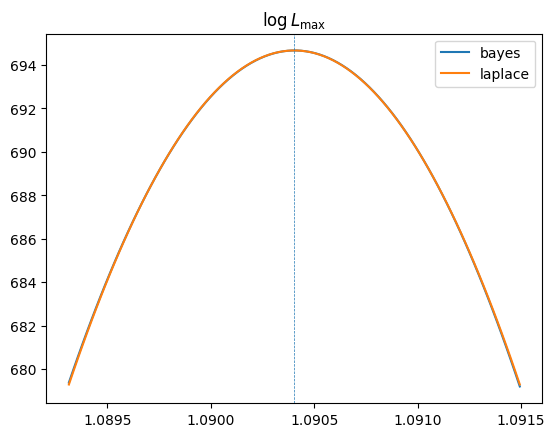

In [256]:
logLmaxs = np.linspace(logLmax0*0.999, logLmax0*1.001, 100)
prs_bayes = np.zeros_like(logLmaxs)
prs_laplace = np.zeros_like(logLmaxs)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, logLmax_ in enumerate(logLmaxs):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax_, d0, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([logLmax_]), logprmax, logLmax0, H[0][0])

# plt.plot(logLmaxs, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
# plt.plot(logLmaxs, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
plt.plot(logLmaxs, prs_bayes, label='bayes')
plt.plot(logLmaxs, prs_laplace, label='laplace')
plt.axvline(x=logLmax0, ls='--', lw=.5)
plt.title('$\log{L_\mathrm{max}}$')
plt.legend();

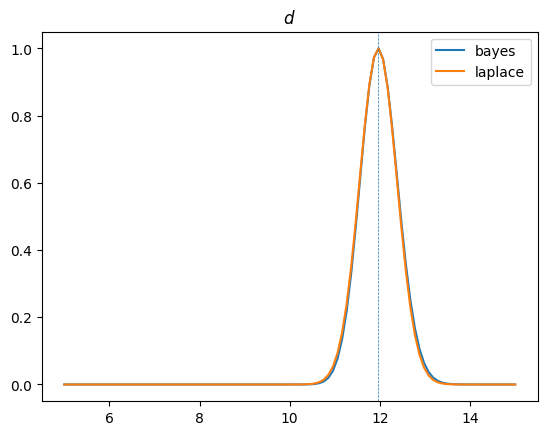

In [257]:
ds = np.linspace(5, 15, 100)
prs_bayes = np.zeros_like(ds)
prs_laplace = np.zeros_like(ds)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, d_ in enumerate(ds):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d_, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([d_]), logprmax, d0, H[1][1])

plt.plot(ds, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
plt.plot(ds, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
# plt.plot(thetas, prs_bayes, label='bayes')
# plt.plot(thetas, prs_laplace, label='laplace')
plt.axvline(x=d0, ls='--', lw=.5)
plt.title('$d$')
plt.legend();

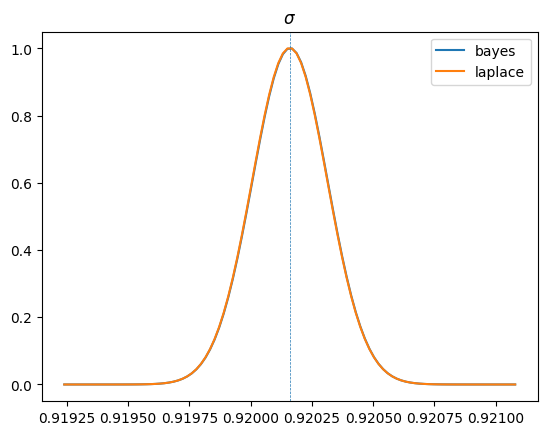

In [258]:
thetas = np.linspace(sigma0*0.999, sigma0*1.001, 100)
prs_bayes = np.zeros_like(thetas)
prs_laplace = np.zeros_like(thetas)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, theta in enumerate(thetas):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d0, theta])
    prs_laplace[i] = logPr_laplace(np.array([theta]), logprmax, sigma0, H[2][2])

plt.plot(thetas, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
plt.plot(thetas, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
# plt.plot(thetas, prs_bayes, label='bayes')
# plt.plot(thetas, prs_laplace, label='laplace')
plt.axvline(x=sigma0, ls='--', lw=.5)
plt.title('$\sigma$')
plt.legend();

### **Plotting errorbars**

In [378]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {logPr_bayes(y, full, mean_X, covinv_X, theta_max)}')

[0.98634092 9.57027403 1.01396522]
pr(theta_true): 390.2007483494226
pr(theta_b): 390.93179857557004


In [379]:
H = hess(y, mean_X, covinv_X, theta_max)
A = -H
cov_theta = np.linalg.inv(A)
H

array([[-2.49727711e+07,  7.76912012e+03, -2.37806614e+07],
       [ 7.76912012e+03, -1.25720980e+02,  2.51257117e+03],
       [-2.37806614e+07,  2.51257117e+03, -2.26979885e+07]])

/tmp/ipykernel_9736/2456065032.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


(0.56, 0.59)

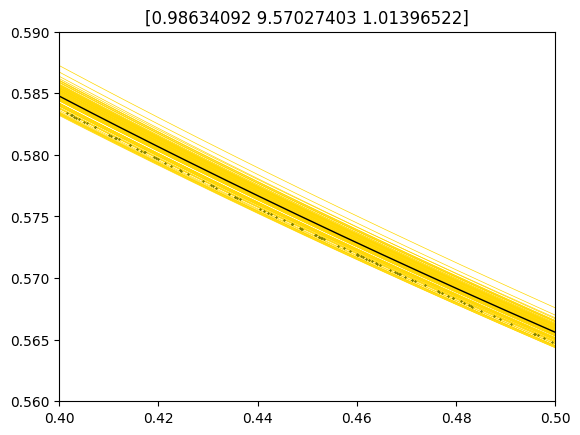

In [380]:
for i in range(100):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    plt.plot(X_b, y, lw=.5, color='gold')
plt.plot(X, y, 'x', ms=1, label='true', color='olive')
plt.plot(full.inverse(y, theta_max), y, lw=1, color='black')
plt.title(theta_max)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)

/tmp/ipykernel_9736/573191231.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


(0.56, 0.59)

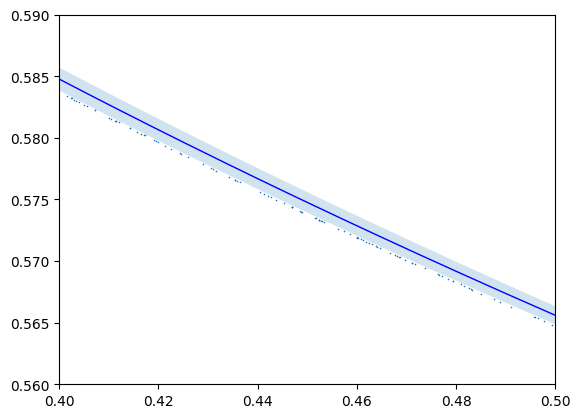

In [381]:
samples = 100
Xarrays = np.zeros((samples, len(y)))
for i in range(samples):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    Xarrays[i] = X_b
X_std = Xarrays.T.std(axis=1)

X_b = full.inverse(y, theta_max)
plt.plot(X_b, y, lw=1, color='blue')
plt.fill_betweenx(y, X_b - X_std, X_b + X_std, alpha=0.2)
plt.plot(X, y, 'x', ms=.5)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)